In [2]:

!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.1 MB/s eta 0:00:00


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim


In [4]:
data = pd.read_csv("Enron.csv", on_bad_lines='skip')
print(data.shape)

(29767, 3)


In [5]:
data

,subject,body,label
0,"hpl nom for may 25 , 2001",( see attached file : hplno 525 . xls )\r\n- h...,0
1,re : nom / actual vols for 24 th,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"enron actuals for march 30 - april 1 , 201","estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,"hpl nom for may 30 , 2001",( see attached file : hplno 530 . xls )\r\n- h...,0
4,"hpl nom for june 1 , 2001",( see attached file : hplno 601 . xls )\r\n- h...,0
...,...,...,...
29762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1
29763,important information,love - potion for your darling is all you want...,1
29764,vys - make itnger,you have feelings of guilt and embarrassment ...,1
29765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1


In [6]:
data.dropna()

,subject,body,label
0,"hpl nom for may 25 , 2001",( see attached file : hplno 525 . xls )\r\n- h...,0
1,re : nom / actual vols for 24 th,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"enron actuals for march 30 - april 1 , 201","estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,"hpl nom for may 30 , 2001",( see attached file : hplno 530 . xls )\r\n- h...,0
4,"hpl nom for june 1 , 2001",( see attached file : hplno 601 . xls )\r\n- h...,0
...,...,...,...
29762,confidence is back,"hello ,\r\nmy boyfriend began having problems ...",1
29763,important information,love - potion for your darling is all you want...,1
29764,vys - make itnger,you have feelings of guilt and embarrassment ...,1
29765,the best thing come in large parcels,spur - m formula\r\nincrease sperm production ...,1


In [7]:
data = data[['body','label']]

In [8]:
data

,body,label
0,( see attached file : hplno 525 . xls )\r\n- h...,0
1,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,( see attached file : hplno 530 . xls )\r\n- h...,0
4,( see attached file : hplno 601 . xls )\r\n- h...,0
...,...,...
29762,"hello ,\r\nmy boyfriend began having problems ...",1
29763,love - potion for your darling is all you want...,1
29764,you have feelings of guilt and embarrassment ...,1
29765,spur - m formula\r\nincrease sperm production ...,1


In [9]:
# --- Feature Extraction ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


def prepare_features(dataframe, text_column="body", label_column="label"):
    """
    Convert raw text into TF–IDF vectors and split into train/test sets.
    """

    # Extract inputs and labels
    texts = dataframe[text_column]
    labels = dataframe[label_column]

    # TF-IDF transformer
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words="english"
    )

    features = vectorizer.fit_transform(texts)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size=0.2,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, vectorizer
X_train, X_test, y_train, y_test, tfidf_model = prepare_features(data)

In [34]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Legitimate", "Phishing"],
        yticklabels=["Legitimate", "Phishing"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [36]:
# Model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9759036144578314


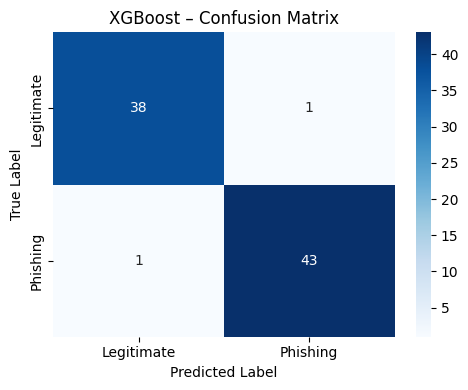

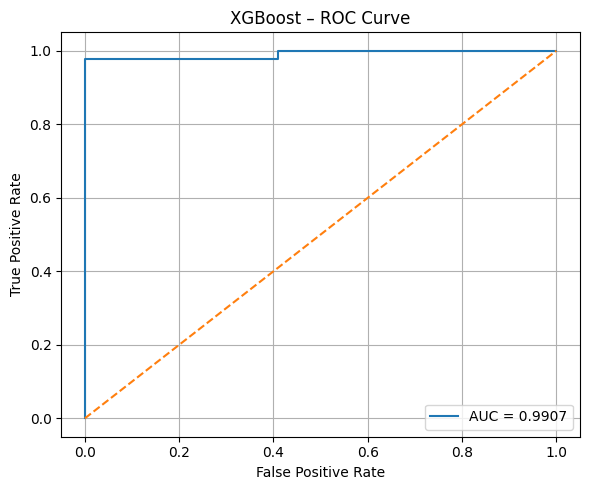

,precision,recall,f1-score,support
Legitimate,0.974359,0.974359,0.974359,39.000000
Phishing,0.977273,0.977273,0.977273,44.000000
accuracy,0.975904,0.975904,0.975904,0.975904
macro avg,0.975816,0.975816,0.975816,83.000000
weighted avg,0.975904,0.975904,0.975904,83.000000


from matplotlib import pyplot as plt
df_report['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [39]:
y_prob_xgb = model.predict_proba(X_test)[:, 1]


y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

plot_confusion(y_test, y_pred_xgb, "XGBoost – Confusion Matrix")


plot_roc(y_test, y_prob_xgb, "XGBoost – ROC Curve")


report = classification_report(
    y_test,
    y_pred_xgb,
    target_names=["Legitimate", "Phishing"],
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
df_report

In [40]:


model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    task_type='GPU',
    verbose=100

)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

0:	learn: 0.6426506	total: 134ms	remaining: 40s
100:	learn: 0.1896109	total: 6.16s	remaining: 12.1s
200:	learn: 0.1320333	total: 11.7s	remaining: 5.75s
299:	learn: 0.1076128	total: 17s	remaining: 0us
Accuracy: 0.9879518072289156


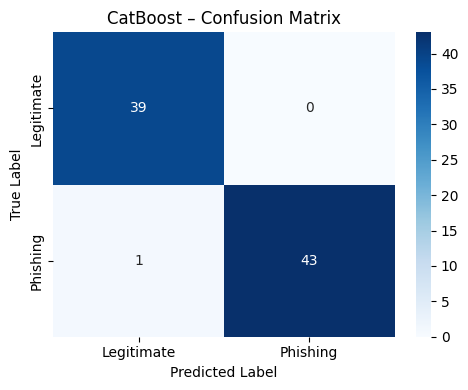

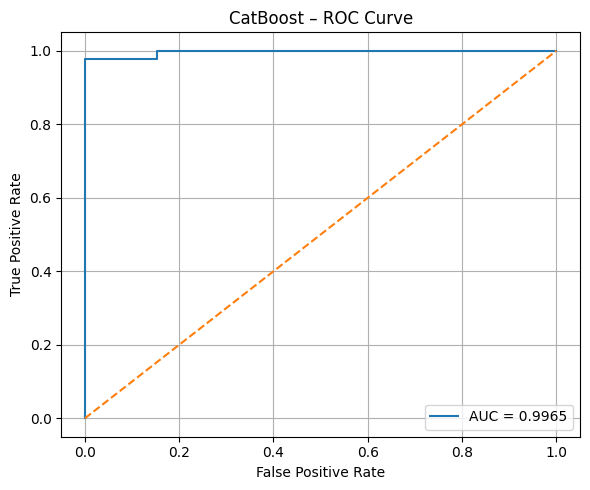

,precision,recall,f1-score,support
Legitimate,0.974359,0.974359,0.974359,39.000000
Phishing,0.977273,0.977273,0.977273,44.000000
accuracy,0.975904,0.975904,0.975904,0.975904
macro avg,0.975816,0.975816,0.975816,83.000000
weighted avg,0.975904,0.975904,0.975904,83.000000


from matplotlib import pyplot as plt
df_report['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [41]:
# Probability prediction
y_prob_cb = model.predict_proba(X_test)[:, 1]

# Binary prediction
y_pred_cb = (y_prob_cb >= 0.5).astype(int)

plot_confusion(y_test, y_pred_cb, "CatBoost – Confusion Matrix")
plot_roc(y_test, y_prob_cb, "CatBoost – ROC Curve")


report = classification_report(
    y_test,
    y_pred_xgb,
    target_names=["Legitimate", "Phishing"],
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
df_report

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.out(x))


In [43]:
# Sparse → Dense
X_train_dense = X_train.toarray()  # Əgər X_train sparse matrixdirsə
X_test_dense = X_test.toarray()

# PyTorch tensor yaratmaq
X_train_t = torch.tensor(X_train_dense, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test_dense, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [44]:
model = NeuralNet(X_train_t.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6926
Epoch 10, Loss: 0.6700
Epoch 20, Loss: 0.6190
Epoch 30, Loss: 0.5293
Epoch 40, Loss: 0.4006
Epoch 50, Loss: 0.2663
Epoch 60, Loss: 0.1708
Epoch 70, Loss: 0.1174
Epoch 80, Loss: 0.0891
Epoch 90, Loss: 0.0730
Epoch 100, Loss: 0.0630
Epoch 110, Loss: 0.0555
Epoch 120, Loss: 0.0502
Epoch 130, Loss: 0.0457
Epoch 140, Loss: 0.0419
Epoch 150, Loss: 0.0389
Epoch 160, Loss: 0.0362
Epoch 170, Loss: 0.0336
Epoch 180, Loss: 0.0315
Epoch 190, Loss: 0.0291


In [45]:
with torch.no_grad():
    y_pred_prob = model(X_train_t)
    y_pred = (y_pred_prob >= 0.5).float()
    correct = (y_pred == y_train_t).sum().item()
    total = y_train_t.size(0)
    accuracy = correct / total
    print(f"Training Accuracy: {accuracy:.4f}")

Training Accuracy: 0.9924


In [46]:
model.eval()
with torch.no_grad():
    y_prob_nn = model(X_test_t).numpy().flatten()

y_pred_nn = (y_prob_nn >= 0.5).astype(int)

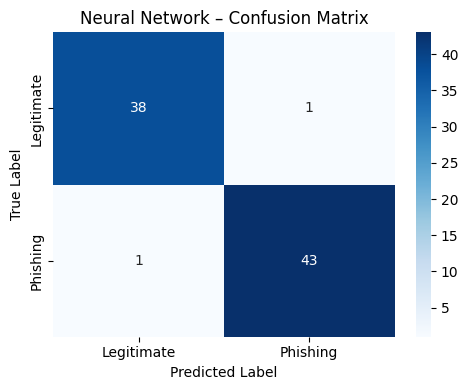

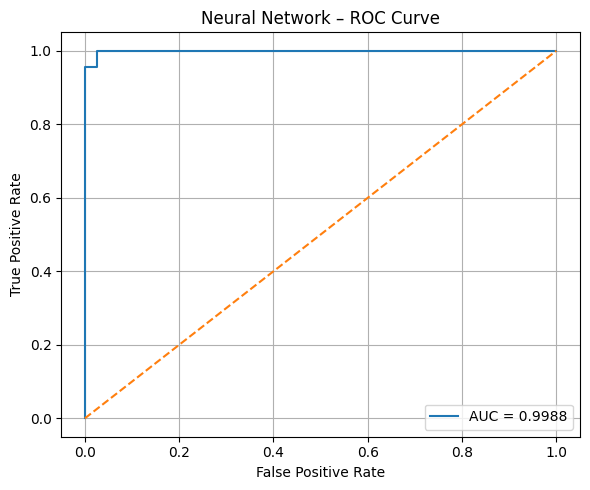

,precision,recall,f1-score,support
Legitimate,0.974359,0.974359,0.974359,39.000000
Phishing,0.977273,0.977273,0.977273,44.000000
accuracy,0.975904,0.975904,0.975904,0.975904
macro avg,0.975816,0.975816,0.975816,83.000000
weighted avg,0.975904,0.975904,0.975904,83.000000


from matplotlib import pyplot as plt
df_report['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [47]:
plot_confusion(y_test, y_pred_nn, "Neural Network – Confusion Matrix")
plot_roc(y_test, y_prob_nn, "Neural Network – ROC Curve")


report = classification_report(
    y_test,
    y_pred_xgb,
    target_names=["Legitimate", "Phishing"],
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
df_report


In [48]:
data2= pd.read_csv("phishing_email.csv")

In [49]:
data

,body,label
0,( see attached file : hplno 525 . xls )\r\n- h...,0
1,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,( see attached file : hplno 530 . xls )\r\n- h...,0
4,( see attached file : hplno 601 . xls )\r\n- h...,0
...,...,...
29762,"hello ,\r\nmy boyfriend began having problems ...",1
29763,love - potion for your darling is all you want...,1
29764,you have feelings of guilt and embarrassment ...,1
29765,spur - m formula\r\nincrease sperm production ...,1


In [50]:
data2.dropna()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [51]:
def prepare_features(dataframe, text_column="text_combined", label_column="label"):
    """
    Convert raw text into TF–IDF vectors and split into train/test sets.
    """

    # Extract inputs and labels
    texts = dataframe[text_column]
    labels = dataframe[label_column]

    # TF-IDF transformer
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words="english"
    )

    features = vectorizer.fit_transform(texts)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size=0.001,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, vectorizer
X_train, X_test, y_train, y_test, tfidf_model = prepare_features(data2)

In [52]:
# Sparse → Dense
X_train_dense = X_train.toarray()  # Əgər X_train sparse matrixdirsə
X_test_dense = X_test.toarray()

# PyTorch tensor yaratmaq
X_train_t = torch.tensor(X_train_dense, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_t = torch.tensor(X_test_dense, dtype=torch.float32)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [53]:
with torch.no_grad():
    y_pred_prob = model(X_train_t)
    y_pred = (y_pred_prob >= 0.5).float()
    correct = (y_pred == y_train_t).sum().item()
    total = y_train_t.size(0)
    accuracy = correct / total
    print(f"Training Accuracy: {accuracy:.4f}")

Training Accuracy: 0.9940


In [54]:
model.eval()
with torch.no_grad():
    y_prob_nn = model(X_test_t).numpy().flatten()

y_pred_nn = (y_prob_nn >= 0.5).astype(int)

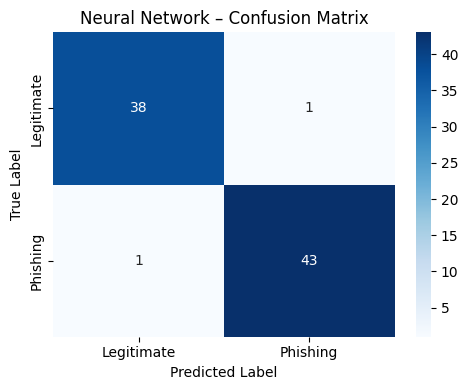

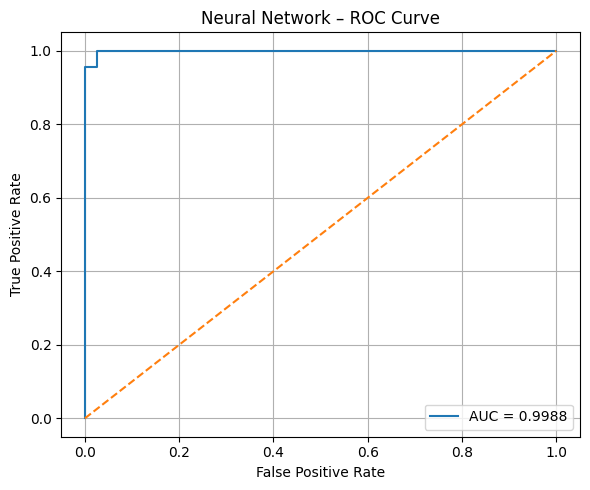

,precision,recall,f1-score,support
Legitimate,0.974359,0.974359,0.974359,39.000000
Phishing,0.977273,0.977273,0.977273,44.000000
accuracy,0.975904,0.975904,0.975904,0.975904
macro avg,0.975816,0.975816,0.975816,83.000000
weighted avg,0.975904,0.975904,0.975904,83.000000


from matplotlib import pyplot as plt
df_report['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='hist', bins=20, title='support')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report.plot(kind='scatter', x='f1-score', y='support', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_report['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_report['support'].plot(kind='line', figsize=(8, 4), title='support')
plt.gca().spines[['top', 'right']].set_visible(False)

In [56]:
plot_confusion(y_test, y_pred_nn, "Neural Network – Confusion Matrix")
plot_roc(y_test, y_prob_nn, "Neural Network – ROC Curve")

report = classification_report(
    y_test,
    y_pred_xgb,
    target_names=["Legitimate", "Phishing"],
    output_dict=True
)

df_report = pd.DataFrame(report).transpose()
df_report
